<a href="https://colab.research.google.com/github/validatehealth/actuary/blob/master/Copy_of_Racine_v3_hierarchy_identifier_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose
The purpose of this Notebook is to generate automated observations for project Racine.  It's simplified in that it generates:
1. Descriptive statistics (such as outliers) for 2 cohort levels: within TIN and within ACO
2. Observations based on correlations between metrics and TIN-level SS 

# vh_core_lite setup

In [1]:
import urllib    # TODO: Use requests instead of urllib
import os
from google.colab import drive
import yaml

def mount_content():
  # go to root (content) dir
  %cd /content/
  # mount your drive
  drive.mount('/content/gdrive')

def clone_vh_core(user, passwd):
  """
    user: your GH username
    passwd: your GH password or access token
  """
  # remove existing vh_core_lite
  %rm -r vh_core_lite
  
  # convert the access_token or password to url format
  access_token = urllib.parse.quote(passwd)
  
  # add auth environment variable
  os.environ['GITHUB_AUTH'] = user + ':' + access_token
  
  # clone the repo. Set depth to 1 to minimize load time
  !git clone --depth 1 https://$GITHUB_AUTH@github.com/validatehealth/vh_core_lite.git

  # download package requirements
  !pip install -r vh_core_lite/requirements.txt

def init_certs():
  # add certs from your gdrive .ssh folder
  %mkdir vh_core_lite/certs/
  !cp /content/gdrive/My\ Drive/.ssh/* vh_core_lite/certs/
  !chmod 400 vh_core_lite/certs/*

def init_awscli():
  %rm awscliv2.zip
  # download aws cli v2
  !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
  !unzip awscliv2.zip
  !./aws/install
  # remove existing files
  %rm -rf /root/.aws/
  %mkdir /root/.aws/
  # copy aws credentials
  %cp /content/gdrive/My\ Drive/.ssh/.aws/* /root/.aws/

# Initialize
mount_content()
clone_vh_core('AaronCC', '4a017ba1defcabb9dc09c00245995040256c488a')
init_certs()
init_awscli()

Streaming output truncated to the last 5000 lines.
  inflating: aws/dist/botocore/data/migrationhub-config/2019-06-30/service-2.json  
   creating: aws/dist/botocore/data/cloudsearchdomain/2013-01-01/
  inflating: aws/dist/botocore/data/cloudsearchdomain/2013-01-01/examples-1.json  
  inflating: aws/dist/botocore/data/cloudsearchdomain/2013-01-01/service-2.json  
   creating: aws/dist/botocore/data/appconfig/2019-10-09/
  inflating: aws/dist/botocore/data/appconfig/2019-10-09/paginators-1.json  
  inflating: aws/dist/botocore/data/appconfig/2019-10-09/service-2.json  
   creating: aws/dist/botocore/data/iotevents-data/2018-10-23/
  inflating: aws/dist/botocore/data/iotevents-data/2018-10-23/paginators-1.json  
  inflating: aws/dist/botocore/data/iotevents-data/2018-10-23/service-2.json  
   creating: aws/dist/botocore/data/sesv2/2019-09-27/
  inflating: aws/dist/botocore/data/sesv2/2019-09-27/paginators-1.json  
  inflating: aws/dist/botocore/data/sesv2/2019-09-27/service-2.json  
   c

In [11]:
def whitelist_ip():
  """
  whitelist the current ip address and revoke the old one
  """
  # get the current ip address
  colab_ip = !curl ipecho.net/plain 
  colab_ip = colab_ip[0]
  # set env var for current ip address
  %set_env COLAB_IP=$colab_ip
  # revoke the old ip

  # TODO: determine method of identifying the 'old' ip address
  # aws ec2 revoke-security-group-ingress \\
  #    --group-name MySecurityGroup \\
  #    --protocol tcp \\
  #    --port 22 
  #    --cidr 203.0.113.0/24

  # add the new ip
  #os.environ['COLAB_IP'] = ip_addr
  !aws ec2 authorize-security-group-ingress --group-name hippa-dev-secure-colab --protocol tcp --port 5432 --cidr $COLAB_IP/32

whitelist_ip()

env: COLAB_IP=34.73.210.150

Unknown output type: .json


In [12]:
%cd /content/vh_core_lite/
import db_utils as dbu
db = dbu.try_connect()

/content/vh_core_lite


# Data Cleaning 

In [13]:
# specification of client and performance year 
client = 'ccmd'
particip_year = '2019A'
hierarchy = 'tin'
group = 'Department' if hierarchy == 'dpt' else 'TIN'

In [8]:
"""
- load raw data
- data type conversion 
- data cleaning
- necessary imputation/ removal
- subset the data for specific year and specific client
"""

'\n- load raw data\n- data type conversion \n- data cleaning\n- necessary imputation/ removal\n- subset the data for specific year and specific client\n'

In [14]:
executed, df = db.execute_sql("SELECT * from analytics_apcd.air_cogn_metrx_by_netw_partyr;")
#executed1, crt_aco = db.execute_sql("SELECT * from staging_"+client+".cognos_geovar_actual_vs_regional_by_aco_particip_year_comp;")
#executed2, crt_tin = db.execute_sql("SELECT * from staging_"+client+".cognos_geovar_actual_vs_regional_by_tin_particip_year_comp;")
#executed3, crt_npi = db.execute_sql("SELECT * from staging_"+client+".cognos_geovar_actual_vs_regional_by_npi_particip_year_comp;")

In [15]:
df.columns

Index(['client', 'particip_year', 'network_level', 'tin', 'npi', 'dpt',
       'tin_name', 'npi_name', 'dpt_name', 'metric_name', 'cognos_category',
       'year_desc', 'agreement_period', 'list_deannualized_sum_value',
       'sum_deannualized_sum_value', 'weight', 'weight_used',
       'list_persyrs_cogn_total', 'persyrs_cogn_total',
       'list_deannualized_sum_value_pbpy', 'dannualized_sum_value_pbpy_1k',
       'deannualized_sum_value_pbpy_perfyr',
       'deannualized_sum_value_pbpy_benchyr',
       'sum_value_pbpy_benchyr_formula'],
      dtype='object')

In [16]:
df.metric_name.value_counts

<bound method IndexOpsMixin.value_counts of 0        computed_tomography__ct__events
1        computed_tomography__ct__events
2        computed_tomography__ct__events
3        computed_tomography__ct__events
4        computed_tomography__ct__events
                      ...               
75703    computed_tomography__ct__events
75704    computed_tomography__ct__events
75705    computed_tomography__ct__events
75706    computed_tomography__ct__events
75707    computed_tomography__ct__events
Name: metric_name, Length: 75708, dtype: object>

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import copy
import matplotlib.pyplot as plt 
from pprint import pprint
from collections import Counter 

# data cleaning
df.replace('-', np.nan)
df.replace(to_replace=['None'], value=np.nan, inplace=True)
df2 = copy.deepcopy(df) 
df_py = df2.particip_year
df_tn = df2.tin_name
df_dpt = df2.dpt_name
df = df.loc[-df.deannualized_sum_value_pbpy_perfyr.isna()]
df = df.loc[-df.deannualized_sum_value_pbpy_benchyr.isna()]
# data conversion 
def df_str_to_numeric(df):
    """
    attempt to convert all df strings to numeric values
    """
    for column in df.columns:
        try:
            #df[column] = df[column].str.replace(',', '')
            df[column] = df[column].str.replace('%', '')
            df[column] = df[column].str.replace('$', '')
            df[column] = pd.to_numeric(df[column])
            #df[column] = df[column].convert_objects(convert_numeric=True)
        except:
            print('failed to convert {}'.format(column))
    return df
df_cleaning = df_str_to_numeric(df)
df_cleaning['particip_year'] = df_py
df_cleaning['particip_year'] = df_cleaning['particip_year'].astype(str)
df_cleaning['diff'] = df_cleaning.deannualized_sum_value_pbpy_perfyr - df_cleaning.deannualized_sum_value_pbpy_benchyr
# get the subset of data for analysis 
df_client = df_cleaning.loc[df_cleaning['client'] == client]
df_client = df_client.loc[df_client['particip_year'] == particip_year] 
# subset the data
df_client_tin = df_client.loc[df_client['network_level'] == 'tin'] 
df_client_npi = df_client.loc[df_client['network_level'] == 'npi']
df_client_both = df_client.loc[df_client['network_level'] == 'full_hierarchy']
df_client_both['tin_name'] =  df_tn
df_client_both['dpt_name'] =  df_dpt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


failed to convert client
failed to convert particip_year
failed to convert network_level
failed to convert dpt
failed to convert tin_name
failed to convert npi_name
failed to convert dpt_name
failed to convert metric_name
failed to convert cognos_category
failed to convert year_desc
failed to convert agreement_period
failed to convert list_deannualized_sum_value
failed to convert weight
failed to convert weight_used
failed to convert list_persyrs_cogn_total
failed to convert list_deannualized_sum_value_pbpy
failed to convert dannualized_sum_value_pbpy_1k
failed to convert sum_value_pbpy_benchyr_formula


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
# pivot for performance year
df_npi1 = pd.crosstab(
    index=df_client_npi['npi_name'], columns=df_client_npi['metric_name'],
    values=df_client_npi['deannualized_sum_value_pbpy_perfyr'], aggfunc=[np.sum]).fillna(0, downcast='infer')
df_npi1.columns = (item +"_perfyr" for item in list(df_npi1.columns.levels[1]))
df_npi2 = df_client_npi.groupby('npi_name').agg({'persyrs_cogn_total':'mean', 'deannualized_sum_value_pbpy_perfyr':'sum', 'deannualized_sum_value_pbpy_benchyr':'sum'})
df_npi = df_npi1.join(df_npi2)
df_npi.reset_index('npi_name')
# pivot for benchmark year
df_npi_benchyr = pd.crosstab(
    index=df_client_npi['npi_name'], columns=df_client_npi['metric_name'],
    values=df_client_npi['deannualized_sum_value_pbpy_benchyr'], aggfunc=[np.sum]).fillna(0, downcast='infer')
df_npi_benchyr.columns = (item +"_benchyr" for item in list(df_npi_benchyr.columns.levels[1]))
df_npi_benchyr.reset_index('npi_name')
# pivot for difference 
df_npi_diff = pd.crosstab(
    index=df_client_npi['npi_name'], columns=df_client_npi['metric_name'],
    values=df_client_npi['diff'], aggfunc=[np.sum]).fillna(0, downcast='infer')
df_npi_diff.columns = (item +"_diff" for item in list(df_npi_diff.columns.levels[1]))
df_npi_diff.reset_index('npi_name')

df_npi = df_npi.join(df_npi_benchyr).join(df_npi_diff)

In [19]:
df_npi

,aged_dual_total_expenditure_amount_perfyr,aged_non_dual_total_expenditure_amount_perfyr,computed_tomography__ct__events_perfyr,disabled_total_expenditure_amount_perfyr,emergency_department_visits_perfyr,emergency_department_visits_that_lead_to_hospitalizations_perfyr,esrd_total_expenditure_amount_perfyr,long_term_stay_hospital_discharges_perfyr,magnetic_resonance_imaging__mri__events_perfyr,primary_care_services_with_a_fqhc/rhc_perfyr,primary_care_services_with_a_nurse_practitioner/physician_assis_perfyr,primary_care_services_with_a_primary_care_physician_perfyr,primary_care_services_with_a_specialist_physician_perfyr,psychiatric_hospital_or_unit_discharges_perfyr,rehabilitation_hospital_or_unit_discharges_perfyr,short_term_stay_hospital_discharges_perfyr,skilled_nursing_facility_or_unit_discharges_perfyr,skilled_nursing_facility_or_unit_utilization_days_perfyr,total_expenditure_amount_perfyr,total_hospital_discharges_perfyr,total_primary_care_services_perfyr,persyrs_cogn_total,deannualized_sum_value_pbpy_perfyr,deannualized_sum_value_pbpy_benchyr,aged_dual_total_expenditure_amount_benchyr,aged_non_dual_total_expenditure_amount_benchyr,computed_tomography__ct__events_benchyr,disabled_total_expenditure_amount_benchyr,emergency_department_visits_benchyr,emergency_department_visits_that_lead_to_hospitalizations_benchyr,esrd_total_expenditure_amount_benchyr,long_term_stay_hospital_discharges_benchyr,magnetic_resonance_imaging__mri__events_benchyr,primary_care_services_with_a_fqhc/rhc_benchyr,primary_care_services_with_a_nurse_practitioner/physician_assis_benchyr,primary_care_services_with_a_primary_care_physician_benchyr,primary_care_services_with_a_specialist_physician_benchyr,psychiatric_hospital_or_unit_discharges_benchyr,rehabilitation_hospital_or_unit_discharges_benchyr,short_term_stay_hospital_discharges_benchyr,skilled_nursing_facility_or_unit_discharges_benchyr,skilled_nursing_facility_or_unit_utilization_days_benchyr,total_expenditure_amount_benchyr,total_hospital_discharges_benchyr,total_primary_care_services_benchyr,aged_dual_total_expenditure_amount_diff,aged_non_dual_total_expenditure_amount_diff,computed_tomography__ct__events_diff,disabled_total_expenditure_amount_diff,emergency_department_visits_diff,emergency_department_visits_that_lead_to_hospitalizations_diff,esrd_total_expenditure_amount_diff,long_term_stay_hospital_discharges_diff,magnetic_resonance_imaging__mri__events_diff,primary_care_services_with_a_fqhc/rhc_diff,primary_care_services_with_a_nurse_practitioner/physician_assis_diff,primary_care_services_with_a_primary_care_physician_diff,primary_care_services_with_a_specialist_physician_diff,psychiatric_hospital_or_unit_discharges_diff,rehabilitation_hospital_or_unit_discharges_diff,short_term_stay_hospital_discharges_diff,skilled_nursing_facility_or_unit_discharges_diff,skilled_nursing_facility_or_unit_utilization_days_diff,total_expenditure_amount_diff,total_hospital_discharges_diff,total_primary_care_services_diff
npi_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"AGATEP, JAMES",38055.526,0.000,200,52951.747,1333,867,0.000,133,0,0,13733,6733,8200,0,0,867,1201.200,23089.066,41034.770,1000,28667,51.916667,218065.309,213623.712,36138.245,0.000,906.500,47934.827,1204.9,950.200,0.000,8.900,291.600,0.000,10611.100,7014.100,9822.300,64.2,0.0,928.600,1582.782,30498.868,37216.790,1002.000,27447.800,1917.281,0.000,-706.500,5016.920,128.1,-83.200,0.000,124.100,-291.600,0.000,3121.900,-281.100,-1622.300,-64.2,0.0,-61.600,-381.582,-7409.802,3817.980,-2.000,1219.200
"AGBOLA, VICTORIA",44524.508,64627.806,2370,90573.476,2148,1333,0.000,74,148,0,12370,4370,3704,148,0,1556,2076.074,85271.186,63527.994,1778,20667,62.916667,401267.044,234437.731,18530.817,32302.683,1112.400,35873.921,1995.5,761.500,0.000,21.000,38.600,0.000,20156.300,9637.500,1670.500,23.5,21.0,899.500,1453.452,49265.016,28243.842,965.700,31465.000,25993.691,32325.123,1257.600,54699.555,152.5,571.500,0.000,53.000,109.400,0.000,-77

In [ ]:
# pivot for corhort difference 
crt_npi = df_str_to_numeric(crt_npi)
crt_npi = crt_npi[crt_npi.particip_year == particip_year]
df_npi_crt = pd.crosstab(
    index=crt_npi['npi_name'], columns=crt_npi['metric_name'],
    values=crt_npi['diff'], aggfunc=[np.sum]).fillna(0, downcast='infer')
df_npi_crt.columns = (item +"_crt_diff" for item in list(df_npi_crt.columns.levels[1]))
#df_npi2 = df_client_npi.groupby('npi_name').agg({'persyrs_cogn_total':'mean', 'deannualized_sum_value_pbpy_perfyr':'sum', 'deannualized_sum_value_pbpy_benchyr':'sum'})
#df_npi = df_npi1.join(df_npi2)
#df_npi.reset_index('npi_name')

failed to convert npi_beatrice_affty
failed to convert npi_name
failed to convert particip_year
failed to convert metric_name


In [ ]:
df_npi = df_npi.join(df_npi_crt)

In [ ]:
# pivot for performance year
df_tin1 = pd.crosstab(
    index=df_client_tin['tin_name'], columns=df_client_tin['metric_name'],
    values=df_client_tin['deannualized_sum_value_pbpy_perfyr'], aggfunc=[np.sum]).fillna(0, downcast='infer')
df_tin1.columns = (item +"_perfyr" for item in list(df_tin1.columns.levels[1]))
df_tin2 = df_client_tin.groupby('tin_name').agg({'persyrs_cogn_total':'mean', 'deannualized_sum_value_pbpy_perfyr':'sum', 'deannualized_sum_value_pbpy_benchyr':'sum'})
df_tin = df_tin1.join(df_tin2)
df_tin.reset_index('tin_name')
# pivot for benchmark year
df_tin_benchyr = pd.crosstab(
    index=df_client_tin['tin_name'], columns=df_client_tin['metric_name'],
    values=df_client_tin['deannualized_sum_value_pbpy_benchyr'], aggfunc=[np.sum]).fillna(0, downcast='infer')
df_tin_benchyr.columns = (item +"_benchyr" for item in list(df_tin_benchyr.columns.levels[1]))
df_tin_benchyr.reset_index('tin_name')
# pivot for difference 
df_tin_diff = pd.crosstab(
    index=df_client_tin['tin_name'], columns=df_client_tin['metric_name'],
    values=df_client_tin['diff'], aggfunc=[np.sum]).fillna(0, downcast='infer')
df_tin_diff.columns = (item +"_diff" for item in list(df_tin_diff.columns.levels[1]))
df_tin_diff.reset_index('tin_name')

# combine
df_tin = df_tin.join(df_tin_benchyr).join(df_tin_diff) 

In [ ]:
# pivot for corhort difference 
crt_tin = df_str_to_numeric(crt_tin)
crt_tin = crt_tin[crt_tin.particip_year == particip_year]
df_tin_crt = pd.crosstab(
    index=crt_tin['tin_name'], columns=crt_tin['metric_name'],
    values=crt_tin['diff'], aggfunc=[np.sum]).fillna(0, downcast='infer')
df_tin_crt.columns = (item +"_crt_diff" for item in list(df_tin_crt.columns.levels[1]))
#df_npi2 = df_client_npi.groupby('npi_name').agg({'persyrs_cogn_total':'mean', 'deannualized_sum_value_pbpy_perfyr':'sum', 'deannualized_sum_value_pbpy_benchyr':'sum'})
#df_npi = df_npi1.join(df_npi2)
#df_npi.reset_index('npi_name')

failed to convert tin_name
failed to convert particip_year
failed to convert metric_name


In [ ]:
df_tin = df_tin.join(df_tin_crt)

In [ ]:
if hierarchy == 'dpt':
  # pivot for performance year
  df_tin1 = pd.crosstab(
    index=df_client_both['dpt_name'], columns=df_client_both['metric_name'],
    values=df_client_both['deannualized_sum_value_pbpy_perfyr'], aggfunc=[np.sum]).fillna(0, downcast='infer')
  df_tin1.columns = (item +"_perfyr" for item in list(df_tin1.columns.levels[1]))
  df_tin2 = df_client_both.groupby('dpt_name').agg({'persyrs_cogn_total':'mean', 'deannualized_sum_value_pbpy_perfyr':'sum', 'deannualized_sum_value_pbpy_benchyr':'sum'})
  df_tin = df_tin1.join(df_tin2)
  df_tin.reset_index('dpt_name')
  # pivot for benchmark year
  df_tin_benchyr = pd.crosstab(
    index=df_client_both['dpt_name'], columns=df_client_both['metric_name'],
    values=df_client_both['deannualized_sum_value_pbpy_benchyr'], aggfunc=[np.sum]).fillna(0, downcast='infer')
  df_tin_benchyr.columns = (item +"_benchyr" for item in list(df_tin_benchyr.columns.levels[1]))
  df_tin_benchyr.reset_index('dpt_name')
  # pivot for difference 
  df_tin_diff = pd.crosstab(
    index=df_client_both['dpt_name'], columns=df_client_both['metric_name'],
    values=df_client_both['diff'], aggfunc=[np.sum]).fillna(0, downcast='infer')
  df_tin_diff.columns = (item +"_diff" for item in list(df_tin_diff.columns.levels[1]))
  df_tin_diff.reset_index('dpt_name')
  # pivot for cohort difference 
  crt_tin = df_str_to_numeric(crt_tin)
  crt_tin = crt_tin[crt_tin.particip_year == particip_year]
  df_tin_crt = pd.crosstab(
    index=crt_tin['dpt_name'], columns=crt_tin['metric_name'],
    values=crt_tin['diff'], aggfunc=[np.sum]).fillna(0, downcast='infer')
  df_tin_crt.columns = (item +"_crt_diff" for item in list(df_tin_crt.columns.levels[1]))

  # combine
  df_tin = df_tin.join(df_tin_benchyr).join(df_tin_diff).join(df_tin_crt) 


In [ ]:
tin_npi_combo = df_client_both.groupby(['tin_name', 'npi_name']).count().reset_index().loc[:,['tin_name', 'npi_name']]
if hierarchy == 'dpt':
  tin_npi_combo = df_client_both.groupby(['dpt_name', 'npi_name']).count().reset_index().loc[:,['dpt_name', 'npi_name']]
df_both = df_npi.merge(tin_npi_combo, on='npi_name').set_index('npi_name')

# Feature loading
- utilization metrics from performance year
- utilization metrics from benchmark years 
- increase in utilization between the two checkpoints 
- utilization difference compared to cohort mean
- percentile in utilization difference compared to cohort mean 

In [ ]:
"""
Create derived calcs for perf year vs bench years
- create computed label
- record utilization metrics for performance year
- record utilization metrics for benchmark years 
- record utilization metrics for increase from benchmark years 
"""

'\nCreate derived calcs for perf year vs bench years\n- create computed label\n- record utilization metrics for performance year\n- record utilization metrics for benchmark years \n- record utilization metrics for increase from benchmark years \n'

In [ ]:
df_npi['target'] = (df_npi.total_expenditure_amount_benchyr - df_npi.total_expenditure_amount_perfyr)/df_npi.total_expenditure_amount_benchyr
df_tin['target'] = (df_tin.total_expenditure_amount_benchyr - df_tin.total_expenditure_amount_perfyr)/df_tin.total_expenditure_amount_benchyr
df_both['target'] = (df_both.total_expenditure_amount_benchyr - df_both.total_expenditure_amount_perfyr)/df_both.total_expenditure_amount_benchyr

In [ ]:
utilization_perfyr = ['computed_tomography__ct__events_perfyr',
       'emergency_department_visits_perfyr',
       'emergency_department_visits_that_lead_to_hospitalizations_perfyr',
       'long_term_stay_hospital_discharges_perfyr',
       'magnetic_resonance_imaging__mri__events_perfyr',
       'primary_care_services_with_a_fqhc/rhc_perfyr',
       'primary_care_services_with_a_nurse_practitioner/physician_assis_perfyr',
       'primary_care_services_with_a_primary_care_physician_perfyr',
       'primary_care_services_with_a_specialist_physician_perfyr',
       'psychiatric_hospital_or_unit_discharges_perfyr',
       'rehabilitation_hospital_or_unit_discharges_perfyr',
       'short_term_stay_hospital_discharges_perfyr',
       'skilled_nursing_facility_or_unit_discharges_perfyr',
       'skilled_nursing_facility_or_unit_utilization_days_perfyr']

utilization_benchyr = ['computed_tomography__ct__events_benchyr',
       'emergency_department_visits_benchyr',
       'emergency_department_visits_that_lead_to_hospitalizations_benchyr',
       'long_term_stay_hospital_discharges_benchyr',
       'magnetic_resonance_imaging__mri__events_benchyr',
       'primary_care_services_with_a_fqhc/rhc_benchyr',
       'primary_care_services_with_a_nurse_practitioner/physician_assis_benchyr',
       'primary_care_services_with_a_primary_care_physician_benchyr',
       'primary_care_services_with_a_specialist_physician_benchyr',
       'psychiatric_hospital_or_unit_discharges_benchyr',
       'rehabilitation_hospital_or_unit_discharges_benchyr',
       'short_term_stay_hospital_discharges_benchyr',
       'skilled_nursing_facility_or_unit_discharges_benchyr',
       'skilled_nursing_facility_or_unit_utilization_days_benchyr']

utilization_diff = ['computed_tomography__ct__events_diff',
       'emergency_department_visits_diff',
       'emergency_department_visits_that_lead_to_hospitalizations_diff',
       'long_term_stay_hospital_discharges_diff',
       'magnetic_resonance_imaging__mri__events_diff',
       'primary_care_services_with_a_fqhc/rhc_diff',
       'primary_care_services_with_a_nurse_practitioner/physician_assis_diff',
       'primary_care_services_with_a_primary_care_physician_diff',
       'primary_care_services_with_a_specialist_physician_diff',
       'psychiatric_hospital_or_unit_discharges_diff',
       'rehabilitation_hospital_or_unit_discharges_diff',
       'short_term_stay_hospital_discharges_diff',
       'skilled_nursing_facility_or_unit_discharges_diff',
       'skilled_nursing_facility_or_unit_utilization_days_diff']

bene = ['persyrs_cogn_total']

In [ ]:
"""
Generate statistics across ACO, TIN, Department
 - mean, median, mode, quartiles, standard deviation for each metrics for ACO 
 - mean, median, mode, quartiles, standard deviation for each metrics for TIN
 - mean, median, mode, quartiles, standard deviation for each metrics for Department  
Create calculations of derived in relation to perf vs bench
 - mean, median, mode, quartiles, standard deviation for each metric increase for ACO 
 - mean, median, mode, quartiles, standard deviation for each metric increase for TIN 
 - mean, median, mode, quartiles, standard deviation for each metric increase for Department 
"""

'\nGenerate statistics across ACO, TIN, Department\n - mean, median, mode, quartiles, standard deviation for each metrics for ACO \n - mean, median, mode, quartiles, standard deviation for each metrics for TIN\n - mean, median, mode, quartiles, standard deviation for each metrics for Department  \nCreate calculations of derived in relation to perf vs bench\n - mean, median, mode, quartiles, standard deviation for each metric increase for ACO \n - mean, median, mode, quartiles, standard deviation for each metric increase for TIN \n - mean, median, mode, quartiles, standard deviation for each metric increase for Department \n'

In [ ]:
cohort_diff = ['emergency_department_visits_crt_diff',
       'long_term_stay_hospital_discharges_crt_diff',
       'total_expenditure_amount_crt_diff',
       'total_hospital_discharges_crt_diff',
       'total_primary_care_services_crt_diff']

In [ ]:
utilization_perfyr = [util for util in utilization_perfyr if util in df_tin.columns]
utilization_diff = [util for util in utilization_diff if util in df_tin.columns]
cohort_diff = [util for util in cohort_diff if util in df_tin.columns]
predictors = utilization_diff+utilization_perfyr+cohort_diff
#predictors = [predictor for predictor in predictors if predictor in df_tin.columns]
X = df_npi[predictors]
tin_X = df_tin[predictors]
both_X = df_both[predictors]
y = df_npi['target']
tin_y = df_tin['target']
both_y = df_both['target']

In [ ]:
# scale all numerical features 
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
Xs = sc_X.fit_transform(X)
tin_Xs = sc_X.fit_transform(tin_X)
both_Xs = sc_X.fit_transform(both_X)
Xs = pd.DataFrame(Xs, columns=X.columns)
Xs.index = df_npi.index
tin_Xs = pd.DataFrame(tin_Xs, columns=tin_X.columns)
tin_Xs.index = df_tin.index
both_Xs = pd.DataFrame(both_Xs, columns=both_X.columns)
both_Xs.index = df_both.index
if hierarchy == 'dpt':
  both_Xs['tin_name'] = df_both.dpt_name
else:
  both_Xs['tin_name'] = df_both.tin_name
#both_Xs.index = df_both.index

# Triming and Outlier detection 

- exclude TINs with limited contribution on shared savings for analysis
- identify outlier TINs after trimming 
- exclude NPIs with limited contributions on shared savings for each TIN
- identify outliers NPIs within each TIN 


In [ ]:
"""
Three possible approaches for identify outliers 
   * identify outliers as above Q3 or below Q1
   * identify outliers that falls outside of the 1.5*IQR
   * identify outliers through isolation forest algorithm 
Note: the specific approach depends on the number of observations and variance of the values   
"""

'\nThree possible approaches for identify outliers \n   * identify outliers as above Q3 or below Q1\n   * identify outliers that falls outside of the 1.5*IQR\n   * identify outliers through isolation forest algorithm \nNote: the specific approach depends on the number of observations and variance of the values   \n'

In [ ]:
def outliers_iqr_rule(series):
    """
    Calculate a list of outliers from a series using the IQR method

    :param series: pandas series of numerical values
    :returns: low_outliers, high_outliers, outliers: list of index that are outliers from all directions
    """
    q1 = series.quantile(q=0.25)
    q3 = series.quantile(q=0.75)
    iqr = q3 - q1
    
    high_outliers = []
    low_outliers = []
    for index, value in series.items():
        if value > q3 + 1.5*iqr:
          high_outliers.append(index)
        if value < q1 - 1.5*iqr:
          low_outliers.append(index)
    
    outliers = high_outliers + low_outliers 

    return low_outliers, high_outliers, outliers

def outliers_3sd(series):
    """
    Calculate a list of outliers from a series using the IQR method

    :param series: pandas series of numerical values
    :returns: low_outliers, high_outliers, outliers: list of index that are outliers from all directions
    """
    high_outliers = []
    low_outliers = []
    for index, value in series.items():
        if value >= 3:
          high_outliers.append(index)
        if value <= -3:
          low_outliers.append(index)
    
    outliers = high_outliers + low_outliers 

    return low_outliers, high_outliers, outliers


def check_outliers_isf(feature_name, dataframe):
  np.seterr(divide='ignore', invalid='ignore')
  model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
  df = dataframe.loc[:,[str(feature_name)]]

  model.fit(df)
  df['scores'] = model.decision_function(df)
  df['anomaly'] = model.predict(df[[str(feature_name)]])

  outliers = list(df.loc[df['anomaly'] == -1].index)
  low_outliers = []
  high_outliers = [] 
  for outlier in outliers:
    value = dataframe.loc[str(outlier), str(feature_name)]
    if value < 0:
      low_outliers.append(outlier)
    else:
      high_outliers.append(outlier)
  
  return low_outliers, high_outliers, outliers

## TIN trimming from total shared savings

In [ ]:
"""
Identify TINs to trim from aggregated shared savings
"""
def trim_tin(df_tin):
  # consider the edge case of empty dataframe
  if df_tin.empty:
    return [], []
  # calculate the aggregated metrics on TIN to reflect variations 
  tin_agg= pd.DataFrame(abs(df_tin.target*df_tin.persyrs_cogn_total).sort_values(), columns=['abs_agg'])
  # calculate percentage of shared savings for each tin
  tin_agg['pct'] = tin_agg['abs_agg'] / tin_agg['abs_agg'].sum()
  # trim the tins with lower than baseline performance -- assuming each tin contributes to the same share of shared savings 
  baseline = 1/(tin_agg.shape[0])

  keep = list(tin_agg.loc[tin_agg['pct'] >= baseline,:].index)
  exclude = list(tin_agg.loc[tin_agg['pct'] < baseline,:].index)

  return keep, exclude

In [ ]:
def visualize_tin(df_tin):
  if df_tin.empty:
    pass
  else:
    tin_agg= pd.DataFrame(abs(df_tin.target*df_tin.persyrs_cogn_total).sort_values(), columns=['abs_agg'])
    tin_agg['pct'] = tin_agg['abs_agg'] / tin_agg['abs_agg'].sum()
    index = tin_agg.index.name
    #tin_agg.plot.bar(y='pct', legend=False, figsize=(7, 7)).set_ylabel('percentage of shared savings')
    plot = alt.Chart(tin_agg.reset_index()).mark_bar().encode(
		y=alt.Y('pct'),
		x=alt.X(index, sort='-y', axis=None),
		tooltip = alt.Tooltip(index))
    plot.display()
    #plt.show()

## TIN outliers detection

In [ ]:
"""
Identify outliers in non-aggregated metrics
"""
def find_outliers(dataframe):
  low_dict = {}
  high_dict = {}
  for feature in dataframe.columns:
    low = outliers_iqr_rule(dataframe[str(feature)])[0]
    high = outliers_iqr_rule(dataframe[str(feature)])[1]
    if low != []:
      low_dict[feature] = low
    if high != []:
      high_dict[feature] = high
  
  return low_dict, high_dict

In [ ]:
"""
Identify characteristics of outliers
"""
def identify_characteristic(outliers_dict, name_list):

  low_dict = {}
  high_dict = {}
  
  for feature, outliers in outliers_dict[0].items():
    focus = list(set(outliers).intersection(set(name_list)))
    if focus != []:
      low_dict[feature] = focus

  for feature, outliers in outliers_dict[1].items():
    focus = list(set(outliers).intersection(set(name_list)))
    if focus != []:
      high_dict[feature] = focus

  return low_dict, high_dict

In [ ]:
tin_pos_ss = list(df_tin.loc[df_tin['target']>0,:].index)
tin_neg_ss = list(df_tin.loc[df_tin['target']<0,:].index)
tins_kept = trim_tin(df_tin[df_tin.index.isin(tin_pos_ss)])[0] + trim_tin(df_tin[df_tin.index.isin(tin_neg_ss)])[0]

In [ ]:
def extract_characteristic_by_tin(characteristic_dict):
    inverse = dict() 
    for key in characteristic_dict: 
        # Go through the list that is saved in the dict:
        for item in characteristic_dict[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new list
                inverse[item] = [key] 
            else: 
                inverse[item].append(key) 
    return inverse

## NPI trimming from total shared savings

In [ ]:
def visualize_savings_loss(df):
  if df.empty:
    pass
  else:   
    df_pos = df.loc[df['target']>0,:]
    df_neg = df.loc[df['target']<0,:]
    pos = df_pos['target'].sum()
    neg = df_neg['target'].abs().sum()
    df_sum = pd.DataFrame(columns=['savings', 'losses'])
    df_sum['savings'] = [pos]
    df_sum['losses'] = [neg]
    df_sum.plot.bar(stacked=True)
    plt.show()

In [ ]:
"""
trim npi within tin through total shared savings
"""
def trim_npis_within_tins(tins, dataframe):
  trim_dict = {}
  for tin in tins:
    print("\n")
    print("For "+tin+": ")
    if hierarchy == 'dpt':
      df = dataframe[dataframe['dpt_name']==str(tin)] 
    else:
      df = dataframe[dataframe['tin_name']==str(tin)] 
    df_pos = df.loc[df['target']>0,:]
    df_neg = df.loc[df['target']<0,:]
    if df.empty:
      print("No specified NPIs")
    else:
      visualize_savings_loss(df)
      print("Shared savings: ")
      if df_pos.empty:
        print("No NPI with positive shared savings")
        trimed_npi_pos = []
      else:
        trimed_npi_pos = trim_tin(df_pos)[0]
        visualize_tin(df_pos)
      print("NPI of focus: "+str(trimed_npi_pos))
      print("Shared losses: ")
      if df_neg.empty:
        print("No NPI with negative shared savings")
        trimed_npi_neg = []
      else:
        trimed_npi_neg = trim_tin(df_neg)[0]
        visualize_tin(df_neg)
      print("NPI of focus: "+str(trimed_npi_neg))
      trim_dict[str(tin)] = trimed_npi_pos+trimed_npi_neg

  return trim_dict

## NPI outliers detection

In [ ]:
"""
find outlier npi in non-aggregated metrics for each tin after trimming
"""
def find_npi_outliers_within_tin(trim_dict, dataframe, features):
  outliers_dict = {}
  
  for tin, npis in trim_dict.items():
    print(tin)
    df = dataframe[dataframe['tin_name']==str(tin)]
    df = df[df.index.isin(npis)]
    if df.empty:
      print("no npis")
      outliers_dict[tin] = ({},{})

    else:
      df[features].boxplot(rot = 90)
      plt.show()
      outliers = find_outliers(df[features])
      print("Low Outliers: ")
      pprint(outliers[0])
      print("High Outliers: ")
      pprint(outliers[1])
      outliers_dict[tin] = outliers

  return outliers_dict  

In [ ]:
def extract_npi_outliers(outliers_dict):
  print("For "+client+" in the participant year of "+particip_year)
  for TIN, NPIs in outliers_dict.items():
    print("\n")
    print("From "+group+" "+TIN)
    print("Low Outlier NPIs: ")
    if len(NPIs[0]) == 0:
      print("None")
    else:
      all_outliers = [NPI for NPIs in list(NPIs[0].values()) for NPI in NPIs]
      value, count = Counter(all_outliers).most_common(1)[0]
      print(str(value) + " for " + str(count) + " features:")
      print(*[" "+str(feature) for feature, NPIs in NPIs[0].items() if value in NPIs], sep = "\n") 
    
    print("High Outlier NPIs: ")
    if len(NPIs[1]) == 0:
      print("None")
    else:
      all_outliers = [NPI for NPIs in list(NPIs[1].values()) for NPI in NPIs]
      value, count = Counter(all_outliers).most_common(1)[0]
      print(str(value) + " for " + str(count) + " features:")
      print(*[" "+str(feature) for feature, NPIs in NPIs[1].items() if value in NPIs], sep = "\n") 

# Result Summary

For CCMD in year 2019A
- Most utilization metrics are positively related with losses
  - TINs with high utilization metrics in primary care service with a fqhc/rhc tend to suffer from losses
  - TINs with high utilization metrics in primary care service with a nurse practitioner/physician assistant tend to suffer from losses
  - TINs with low utilization increase in rehabilitation hospital and emergency department from benchmark years tend to obtain savings 

- Area of focus:
  primary care service seems to be most related to financial losses 

In [ ]:
# visualize shared savings for each TIN
index = df_tin.index.name  
alt.Chart(df_tin.reset_index()).mark_bar().encode(
		y=alt.Y('target', title='Shared Savings Per Person Year:' +" "+client+" "+particip_year+ " for each "+group),
		x=alt.X(index, sort='-y', axis=None),
		tooltip = alt.Tooltip(index),
		color=alt.condition(
        alt.datum.target > 0,
        alt.value("steelblue"),  # The positive color
        alt.value("orange")  # The negative color
    )).interactive()

alt.Chart(...)

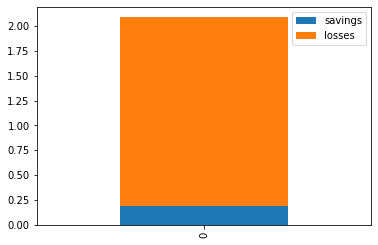

In [ ]:
# visualize total shared savings of ACO 
visualize_savings_loss(df_tin)

In [ ]:
# trim TINs with positive and negative shared savings respectively
print("For "+client+" in the participant year of "+particip_year+":")
print(group + " with savings: ")
visualize_tin(df_tin[df_tin.index.isin(tin_pos_ss)])
print("Extracted "+group+" with savings: ")
print(trim_tin(df_tin[df_tin.index.isin(tin_pos_ss)])[0])
print("\n")
print(group + " with losses: ")
visualize_tin(df_tin[df_tin.index.isin(tin_neg_ss)])
print("Extracted "+group+" with losses: ")
print(trim_tin(df_tin[df_tin.index.isin(tin_neg_ss)])[0])

For ccmd in the participant year of 2019A:
TIN with savings: 


alt.Chart(...)

Extracted TIN with savings: 
['TRANSITIONAL CARE PHYSICIANS OF GEORGIA, PC']


TIN with losses: 


alt.Chart(...)

Extracted TIN with losses: 
['GN MEDICAL ASSOCIATES, INC', 'VISION MEDICAL CONSULTING, P.C.']


In [ ]:
print("For performance year utilizations: ")
# TINs with savings
print("For "+group+" with savings: ")
print("Low Outlier "+group+" Characteristics: ")
pprint(extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_perfyr]), trim_tin(df_tin[df_tin.index.isin(tin_pos_ss)])[0])[0]))
print("High Outlier "+group+" Characteristics: ")
pprint(extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_perfyr]), trim_tin(df_tin[df_tin.index.isin(tin_pos_ss)])[0])[1]))
# TINs with losses 
print("For "+group+" with losses: ")
print("Low Outlier "+group+"  Characteristics: ")
pprint(extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_perfyr]), trim_tin(df_tin[df_tin.index.isin(tin_neg_ss)])[0])[0]))
print("High Outlier "+group+"  Characteristics: ")
pprint(extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_perfyr]), trim_tin(df_tin[df_tin.index.isin(tin_neg_ss)])[0])[1]))
print("\n")

print("For utilization increase from benchmark years: ")
# TINs with savings
print("For "+group+" with savings: ")
print("Low Outlier "+group+"  Characteristics: ")
pprint(extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_diff]), trim_tin(df_tin[df_tin.index.isin(tin_pos_ss)])[0])[0]))
print("High Outlier "+group+"  Characteristics: ")
pprint(extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_diff]), trim_tin(df_tin[df_tin.index.isin(tin_pos_ss)])[0])[1]))
# TINs with losses 
print("For "+group+" with losses: ")
print("Low Outlier "+group+"  Characteristics: ")
pprint(extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_diff]), trim_tin(df_tin[df_tin.index.isin(tin_neg_ss)])[0])[0]))
print("High Outlier "+group+"  Characteristics: ")
pprint(extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_diff]), trim_tin(df_tin[df_tin.index.isin(tin_neg_ss)])[0])[1]))

print("\n")
print("For utilization comparison with cohort: ")
# TINs with savings
print("For "+group+" with savings: ")
print("Low Outlier "+group+"  Characteristics: ")
pprint(extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[cohort_diff]), trim_tin(df_tin[df_tin.index.isin(tin_pos_ss)])[0])[0]))
print("High Outlier "+group+"  Characteristics: ")
pprint(extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[cohort_diff]), trim_tin(df_tin[df_tin.index.isin(tin_pos_ss)])[0])[1]))
# TINs with losses 
print("For "+group+" with losses: ")
print("Low Outlier "+group+"  Characteristics: ")
pprint(extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[cohort_diff]), trim_tin(df_tin[df_tin.index.isin(tin_neg_ss)])[0])[0]))
print("High Outlier "+group+"  Characteristics: ")
pprint(extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[cohort_diff]), trim_tin(df_tin[df_tin.index.isin(tin_neg_ss)])[0])[1]))

For performance year utilizations: 
For TIN with savings: 
Low Outlier TIN Characteristics: 
{}
High Outlier TIN Characteristics: 
{}
For TIN with losses: 
Low Outlier TIN  Characteristics: 
{}
High Outlier TIN  Characteristics: 
{'GN MEDICAL ASSOCIATES, INC': ['primary_care_services_with_a_fqhc/rhc_perfyr'],
 'VISION MEDICAL CONSULTING, P.C.': ['primary_care_services_with_a_nurse_practitioner/physician_assis_perfyr']}


For utilization increase from benchmark years: 
For TIN with savings: 
Low Outlier TIN  Characteristics: 
{'TRANSITIONAL CARE PHYSICIANS OF GEORGIA, PC': ['emergency_department_visits_diff',
                                                 'rehabilitation_hospital_or_unit_discharges_diff']}
High Outlier TIN  Characteristics: 
{}
For TIN with losses: 
Low Outlier TIN  Characteristics: 
{}
High Outlier TIN  Characteristics: 
{'GN MEDICAL ASSOCIATES, INC': ['primary_care_services_with_a_fqhc/rhc_diff'],
 'VISION MEDICAL CONSULTING, P.C.': ['primary_care_services_with_a_nu



For TRANSITIONAL CARE PHYSICIANS OF GEORGIA, PC: 


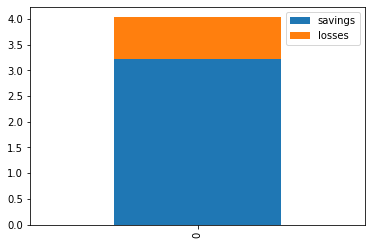

Shared savings: 


alt.Chart(...)

NPI of focus: ['SARGENT, AMY', 'WALTERS, ROBERTA', 'WENDEL, BONITA', 'OREN, HILA']
Shared losses: 


alt.Chart(...)

NPI of focus: ['MOHAN, AMAR']


For GN MEDICAL ASSOCIATES, INC: 


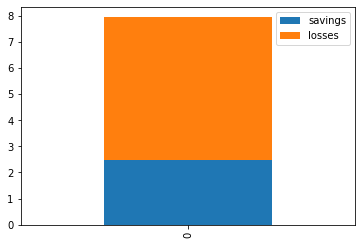

Shared savings: 


alt.Chart(...)

NPI of focus: ['GUIRGIS, IMAN', 'CHANDLER, MATTHEW', 'KEISNER, SUSAN']
Shared losses: 


alt.Chart(...)

NPI of focus: ['JACKSON, BLAINE', 'DHEERIYA, UJJWALA', 'COLLADO, ORLANDO']


For VISION MEDICAL CONSULTING, P.C.: 


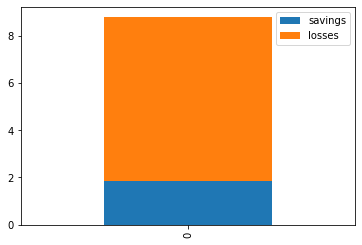

Shared savings: 


alt.Chart(...)

NPI of focus: ['OKENCHI, MICHAEL', 'MAKINDE, ROSELINE', 'SALMON-ANDERSON, TRICIA', 'AGOMESSOU, ABLAVI', 'GARNETT, DESHAWNDA']
Shared losses: 


alt.Chart(...)

NPI of focus: ['HAMMONTREE, SUSANNA', 'CHOI, SONGEUN', 'ANTOINE, PATRICK', 'HANNAN, JOSEPH', 'RAY-LEVERETT, DAPHNE', 'FRINKS, TERENCE']


In [ ]:
# trim NPIs in each TIN 
trim_dict = trim_npis_within_tins(list(tins_kept), df_both)

TRANSITIONAL CARE PHYSICIANS OF GEORGIA, PC


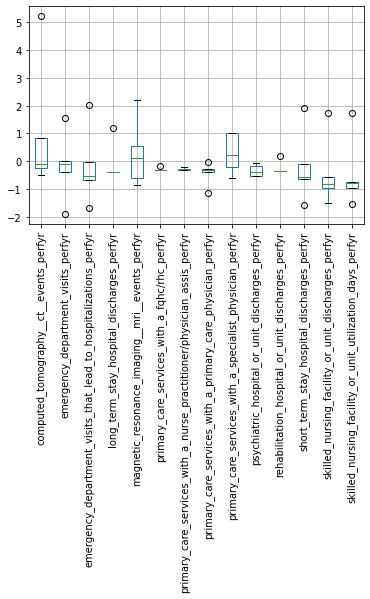

Low Outliers: 
{'emergency_department_visits_perfyr': ['WALTERS, ROBERTA'],
 'emergency_department_visits_that_lead_to_hospitalizations_perfyr': ['WALTERS, '
                                                                      'ROBERTA'],
 'primary_care_services_with_a_primary_care_physician_perfyr': ['WALTERS, '
                                                                'ROBERTA'],
 'short_term_stay_hospital_discharges_perfyr': ['WALTERS, ROBERTA'],
 'skilled_nursing_facility_or_unit_utilization_days_perfyr': ['WALTERS, '
                                                              'ROBERTA']}
High Outliers: 
{'computed_tomography__ct__events_perfyr': ['WALTERS, ROBERTA'],
 'emergency_department_visits_perfyr': ['MOHAN, AMAR'],
 'emergency_department_visits_that_lead_to_hospitalizations_perfyr': ['MOHAN, '
                                                                      'AMAR'],
 'long_term_stay_hospital_discharges_perfyr': ['MOHAN, AMAR'],
 'primary_care_services_with_a_f

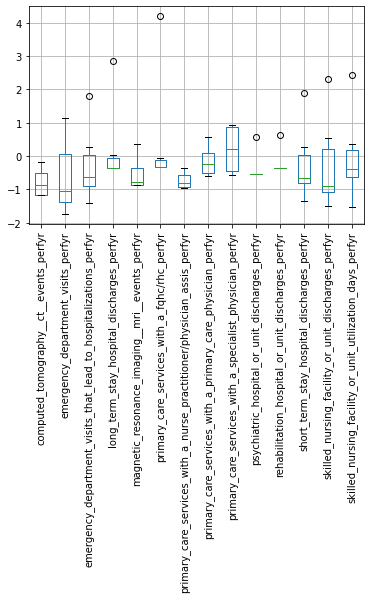

Low Outliers: 
{}
High Outliers: 
{'emergency_department_visits_that_lead_to_hospitalizations_perfyr': ['COLLADO, '
                                                                      'ORLANDO'],
 'long_term_stay_hospital_discharges_perfyr': ['COLLADO, ORLANDO'],
 'primary_care_services_with_a_fqhc/rhc_perfyr': ['DHEERIYA, UJJWALA'],
 'psychiatric_hospital_or_unit_discharges_perfyr': ['COLLADO, ORLANDO'],
 'rehabilitation_hospital_or_unit_discharges_perfyr': ['DHEERIYA, UJJWALA'],
 'short_term_stay_hospital_discharges_perfyr': ['COLLADO, ORLANDO'],
 'skilled_nursing_facility_or_unit_discharges_perfyr': ['COLLADO, ORLANDO'],
 'skilled_nursing_facility_or_unit_utilization_days_perfyr': ['COLLADO, '
                                                              'ORLANDO']}
VISION MEDICAL CONSULTING, P.C.


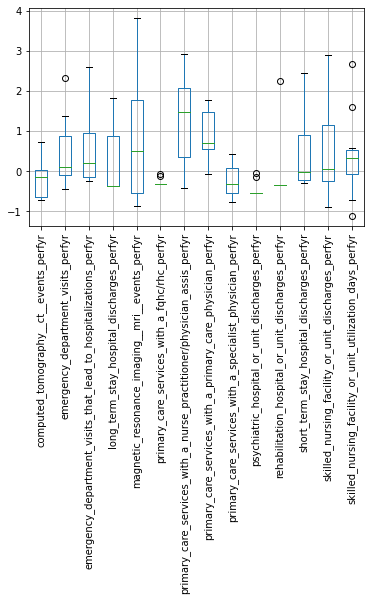

Low Outliers: 
{'skilled_nursing_facility_or_unit_utilization_days_perfyr': ['SALMON-ANDERSON, '
                                                              'TRICIA']}
High Outliers: 
{'emergency_department_visits_perfyr': ['FRINKS, TERENCE'],
 'primary_care_services_with_a_fqhc/rhc_perfyr': ['CHOI, SONGEUN',
                                                  'FRINKS, TERENCE'],
 'psychiatric_hospital_or_unit_discharges_perfyr': ['FRINKS, TERENCE',
                                                    'RAY-LEVERETT, DAPHNE'],
 'rehabilitation_hospital_or_unit_discharges_perfyr': ['FRINKS, TERENCE'],
 'skilled_nursing_facility_or_unit_utilization_days_perfyr': ['FRINKS, TERENCE',
                                                              'RAY-LEVERETT, '
                                                              'DAPHNE']}


In [ ]:
# identify NPI outliers in performance year metrics 
npi_outliers_perf = find_npi_outliers_within_tin(trim_dict, both_Xs, utilization_perfyr) 

TRANSITIONAL CARE PHYSICIANS OF GEORGIA, PC


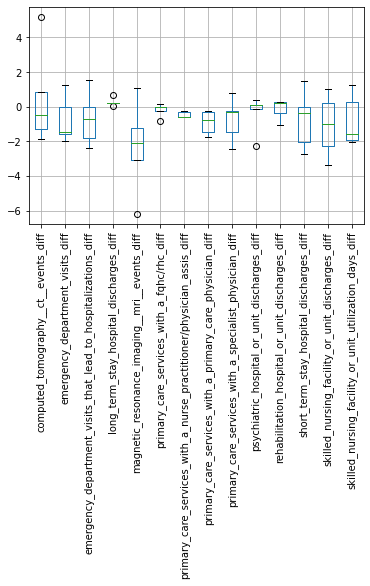

Low Outliers: 
{'long_term_stay_hospital_discharges_diff': ['OREN, HILA'],
 'magnetic_resonance_imaging__mri__events_diff': ['WENDEL, BONITA'],
 'primary_care_services_with_a_fqhc/rhc_diff': ['WALTERS, ROBERTA'],
 'psychiatric_hospital_or_unit_discharges_diff': ['SARGENT, AMY']}
High Outliers: 
{'computed_tomography__ct__events_diff': ['WALTERS, ROBERTA'],
 'long_term_stay_hospital_discharges_diff': ['MOHAN, AMAR']}
GN MEDICAL ASSOCIATES, INC


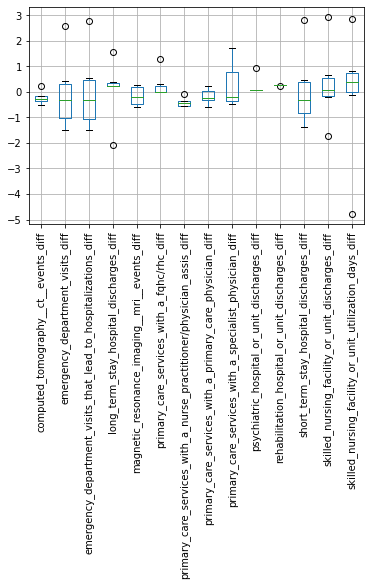

Low Outliers: 
{'long_term_stay_hospital_discharges_diff': ['KEISNER, SUSAN'],
 'rehabilitation_hospital_or_unit_discharges_diff': ['DHEERIYA, UJJWALA'],
 'skilled_nursing_facility_or_unit_discharges_diff': ['CHANDLER, MATTHEW'],
 'skilled_nursing_facility_or_unit_utilization_days_diff': ['CHANDLER, '
                                                            'MATTHEW']}
High Outliers: 
{'computed_tomography__ct__events_diff': ['COLLADO, ORLANDO'],
 'emergency_department_visits_diff': ['COLLADO, ORLANDO'],
 'emergency_department_visits_that_lead_to_hospitalizations_diff': ['COLLADO, '
                                                                    'ORLANDO'],
 'long_term_stay_hospital_discharges_diff': ['COLLADO, ORLANDO'],
 'primary_care_services_with_a_fqhc/rhc_diff': ['DHEERIYA, UJJWALA'],
 'primary_care_services_with_a_nurse_practitioner/physician_assis_diff': ['GUIRGIS, '
                                                                          'IMAN'],
 'psychiatric_hospital

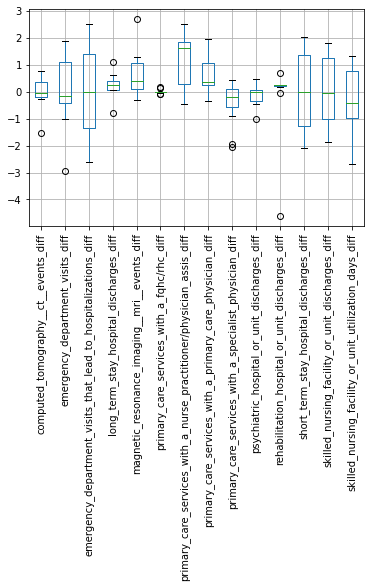

Low Outliers: 
{'computed_tomography__ct__events_diff': ['MAKINDE, ROSELINE'],
 'emergency_department_visits_diff': ['MAKINDE, ROSELINE'],
 'long_term_stay_hospital_discharges_diff': ['AGOMESSOU, ABLAVI'],
 'primary_care_services_with_a_fqhc/rhc_diff': ['ANTOINE, PATRICK',
                                                'MAKINDE, ROSELINE'],
 'primary_care_services_with_a_specialist_physician_diff': ['MAKINDE, ROSELINE',
                                                            'OKENCHI, MICHAEL'],
 'psychiatric_hospital_or_unit_discharges_diff': ['MAKINDE, ROSELINE'],
 'rehabilitation_hospital_or_unit_discharges_diff': ['CHOI, SONGEUN',
                                                     'MAKINDE, ROSELINE']}
High Outliers: 
{'long_term_stay_hospital_discharges_diff': ['RAY-LEVERETT, DAPHNE'],
 'magnetic_resonance_imaging__mri__events_diff': ['HAMMONTREE, SUSANNA'],
 'primary_care_services_with_a_fqhc/rhc_diff': ['CHOI, SONGEUN',
                                                'FRI

In [ ]:
# identify NPI outliers in utilization increase 
npi_outliers_dervd = find_npi_outliers_within_tin(trim_dict, both_Xs, utilization_diff) 

TRANSITIONAL CARE PHYSICIANS OF GEORGIA, PC


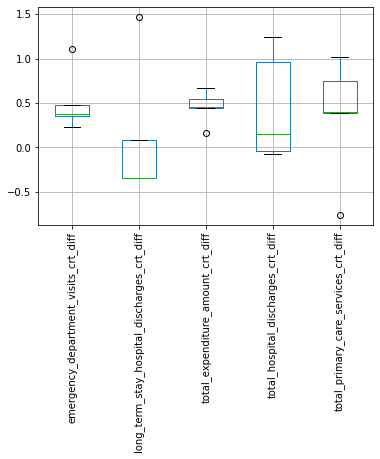

Low Outliers: 
{'total_expenditure_amount_crt_diff': ['MOHAN, AMAR'],
 'total_primary_care_services_crt_diff': ['MOHAN, AMAR']}
High Outliers: 
{'emergency_department_visits_crt_diff': ['WENDEL, BONITA'],
 'long_term_stay_hospital_discharges_crt_diff': ['MOHAN, AMAR']}
GN MEDICAL ASSOCIATES, INC


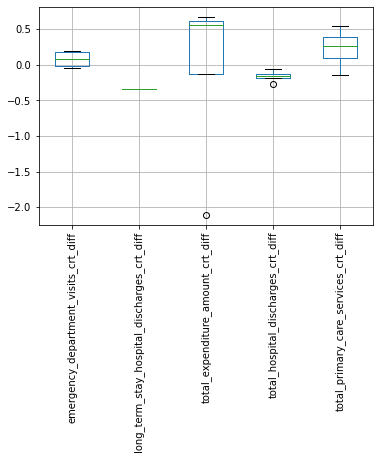

Low Outliers: 
{'total_expenditure_amount_crt_diff': ['COLLADO, ORLANDO'],
 'total_hospital_discharges_crt_diff': ['JACKSON, BLAINE']}
High Outliers: 
{}
VISION MEDICAL CONSULTING, P.C.


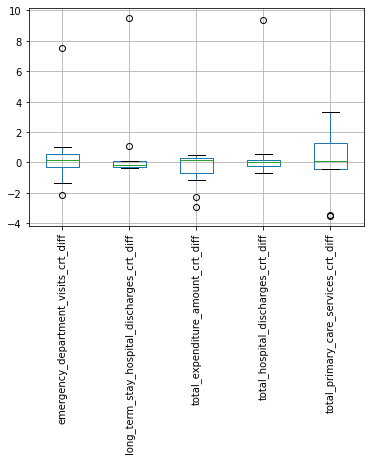

Low Outliers: 
{'emergency_department_visits_crt_diff': ['ANTOINE, PATRICK'],
 'total_expenditure_amount_crt_diff': ['ANTOINE, PATRICK', 'FRINKS, TERENCE'],
 'total_primary_care_services_crt_diff': ['ANTOINE, PATRICK', 'HANNAN, JOSEPH']}
High Outliers: 
{'emergency_department_visits_crt_diff': ['FRINKS, TERENCE'],
 'long_term_stay_hospital_discharges_crt_diff': ['AGOMESSOU, ABLAVI',
                                                 'FRINKS, TERENCE'],
 'total_hospital_discharges_crt_diff': ['FRINKS, TERENCE']}


In [ ]:
# identify NPI outliers in cohort statistics
npi_outliers_crt= find_npi_outliers_within_tin(trim_dict, both_Xs, cohort_diff) 

In [ ]:
print("Outlier NPI in utilization in performance year: ")
extract_npi_outliers(npi_outliers_perf)
print("\n")
print("Outlier NPI in utilization increase from benchmark year: ")
extract_npi_outliers(npi_outliers_dervd)
print("\n")
print("Outlier NPI in utilization comparison from cohort: ")
extract_npi_outliers(npi_outliers_crt)

Outlier NPI in utilization in performance year: 
For ccmd in the participant year of 2019A


From TIN TRANSITIONAL CARE PHYSICIANS OF GEORGIA, PC
Low Outlier NPIs: 
WALTERS, ROBERTA for 5 features:
 emergency_department_visits_perfyr
 emergency_department_visits_that_lead_to_hospitalizations_perfyr
 primary_care_services_with_a_primary_care_physician_perfyr
 short_term_stay_hospital_discharges_perfyr
 skilled_nursing_facility_or_unit_utilization_days_perfyr
High Outlier NPIs: 
MOHAN, AMAR for 8 features:
 emergency_department_visits_perfyr
 emergency_department_visits_that_lead_to_hospitalizations_perfyr
 long_term_stay_hospital_discharges_perfyr
 primary_care_services_with_a_fqhc/rhc_perfyr
 rehabilitation_hospital_or_unit_discharges_perfyr
 short_term_stay_hospital_discharges_perfyr
 skilled_nursing_facility_or_unit_discharges_perfyr
 skilled_nursing_facility_or_unit_utilization_days_perfyr


From TIN GN MEDICAL ASSOCIATES, INC
Low Outlier NPIs: 
None
High Outlier NPIs: 
COLLADO, ORL

In [ ]:
# # result extraction
# import pickle
# # characteristics of tins
# pickle.dump(tins_kept, open("/content/drive/My Drive/data/tins_kept", "wb")) 
# tins_losses_perf_characteristic = extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_perfyr]), trim_tin(df_tin[df_tin.index.isin(tin_pos_ss)])[0])[0]), extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_perfyr]), trim_tin(df_tin[df_tin.index.isin(tin_pos_ss)])[0])[1])
# tins_savings_perf_characteristic = extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_perfyr]), trim_tin(df_tin[df_tin.index.isin(tin_neg_ss)])[0])[0]), extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_perfyr]), trim_tin(df_tin[df_tin.index.isin(tin_neg_ss)])[0])[1])
# tins_losses_dervd_characteristic = extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_diff]), trim_tin(df_tin[df_tin.index.isin(tin_pos_ss)])[0])[0]), extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_diff]), trim_tin(df_tin[df_tin.index.isin(tin_pos_ss)])[0])[1])
# tins_savings_dervd_characteristic = extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_diff]), trim_tin(df_tin[df_tin.index.isin(tin_neg_ss)])[0])[0]), extract_characteristic_by_tin(identify_characteristic(find_outliers(tin_Xs[utilization_diff]), trim_tin(df_tin[df_tin.index.isin(tin_neg_ss)])[0])[1])
# pickle.dump(tins_losses_perf_characteristic, open("/content/drive/My Drive/data/tins_losses_perf_characteristics", "wb"))
# pickle.dump(tins_savings_perf_characteristic, open("/content/drive/My Drive/data/tins_savings_perf_characteristic", "wb"))
# pickle.dump(tins_losses_dervd_characteristic, open("/content/drive/My Drive/data/tins_losses_dervd_characteristic", "wb"))
# pickle.dump(tins_savings_dervd_characteristic, open("/content/drive/My Drive/data/tins_savings_dervd_characteristic", "wb"))
# # characteristics of NPIs 
# pickle.dump(trim_dict, open("/content/drive/My Drive/data/npi_kept", "wb")) 
# npi_perf = extract_npi_outliers(npi_outliers_perf)
# npi_dervd = extract_npi_outliers(npi_outliers_dervd)
# pickle.dump(npi_perf, open("/content/drive/My Drive/data/npi_perf", "wb"))
# pickle.dump(npi_dervd, open("/content/drive/My Drive/data/npi_dervd", "wb"))


In [ ]:
#! pip install nbconvert

In [ ]:
#from google.colab import files

In [ ]:
#files.download("Racine_v3_hierarchy_identifier_updated.ipynb")

In [ ]:
#!jupyter nbconvert --to <output format> <filename.ipynb>

In [ ]:
#!jupyter nbconvert --to html ccmd_2019A.ipynb --no-input

In [ ]:
# !apt update
# !apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

# import re, pathlib, shutil

In [ ]:
# # Get a list of all your Notebooks
# notebooks = [x for x in pathlib.Path("/content").iterdir() if 
#              re.search(r"\.ipynb", x.name, flags = re.I)]

# for i, n in enumerate(notebooks):
#     print(f"\nProcessing  [{i+1:{len(str(len(notebooks)))}d}/{len(notebooks)}]  {n.name}\n")

#     # Optionally copy your notebooks from gdrive to your vm
#     shutil.copy(n, n.name)
#     n = pathlib.Path(n.name)
#     print("{n.as_posix()}")
#     #print("{n.stem.replace(" ", "_")}")
#     #!jupyter nbconvert "{n.as_posix()}" --to pdf --output "{n.stem.replace(" ", "_")}"

In [ ]:
# import os
# cwd = os.getcwd()

In [ ]:
# cwd